# Algoritmo para ejecutar CVA

CVA (Credit Valuation Adjustment) es una técnica que permite calcular la diferencia entre el valor de un portofolio dado y el valor de un portafolio de renta fija, considerando las probabilidades de incumplimiento para cada unidad de tiempo, con el fin de encontrar el valor de mercado de los derivados incluyendo los riesgos de incumplimiento.

Un método que puede explotar las capacidades de Pyhton es el diseño de simulaciones para obtener la exposición futura esperada (EFE) a partir de simulaciones para cada unidad de tiempo. Se propone que la dinámica entre el precio del subyacente en cada unidad de tiempo respecto la anterior se modele a través de un movimiento browniano geométrico.

La fórmula que caracteriza la valuación es: 

$$CVA(T)\,=\,\int_{0}^{T} E^{Q} \left [ LGD \frac{B_{0}}{B_{t}} E(t) | t\,=\,\tau \right ] dPD(0,t)$$

Donde $T$ es la duración del derivado, $B_{t}$ es el valor de una unidad monetaria dada la tasa actual llevada al plazo $t$, $E(t)$ es la exposición al tiempo $t$, $LGD$ es la pérdida esperada dado incumplimiento  y $PD(0,t)$ es la probabilidad que se incumpla en los pagos en alguno de los primeros $t$ periodos de tiempo.

$LGD$ se puede entender en términos simplistas como el porcentaje de deuda que pudiera cubrirse con la venta de activos al tiempo $t$. 

Se puede usar tanto para valuación de derivados como para encontrar el valor de mercado de un portafolio respecto a uno libre de riesgo pero con probabilidad positiva de incumplimiento en los cupones.

# Programa

Este programa realiza dos tareas: i. Calcula la probabilidad de incumplimiento del instrumento en P$ para posteriormente ii. Calcular el CVA usando pronósticos de FX obtenidos mediante simulaciones de Monte Carlo, para posteriomente calcular el MKM y la EPE (promedio de los MKM positivos por periodo de tiempo) y el percentil 95 (EFE) para cada periodo de tiempo. Asumimos que el contrato tiene un plazo de 90 días y los intrumentos de renta fija que se usaron para obtener la probabilidad de incumplimiento pagan semi-anualmente.

## I. Probabilidad de incumplimiento

In [9]:
import datetime
import numpy as np
from datetime import datetime
from scipy.optimize import minimize
from scipy.optimize import Bounds

def inmediato_posterior(d1,d2):
    '''
    Devuelve la fecha inmediatamente después de d1 tomando al número 
    de día de d2.
    '''
    m=d2.month
    d=d2.day
    m6=(m+6)%12
    if m6==0:
        m6=12
    if d1.month < m or (d1.month==m and d>=d1.day):
        resp = datetime.strptime(str(d)+"/"+str(m)+"/"+str(d1.year),"%d/%m/%Y")
    else:
        resp = datetime.strptime(str(d)+"/"+str(m6)+"/"+str(d1.year),"%d/%m/%Y")
    return resp
        

def fecha_6M(d1):
    '''
    Entrega la fecha con el mismo número de día exactamente 6 meses después 
    '''
    if (d1.month+6)%12 == 0:
        m2=12
    else:
        m2=(d1.month+6)%12
    if d1.month+6 >12:
        y2=d1.year+1
    else:
        y2=d1.year
    d2=str(d1.day)+"/"+str(m2)+"/"+str(y2)
    return datetime.strptime(d2,"%d/%m/%Y")

def days360(start_date, end_date, method_eu=False):
    '''
    Replica lo que hace dias360 de Excel.
    '''
    start_day = start_date.day
    start_month = start_date.month
    start_year = start_date.year
    end_day = end_date.day
    end_month = end_date.month
    end_year = end_date.year

    if (
        start_day == 31 or
        (
            method_eu is False and
            start_month == 2 and (
                start_day == 29 or (
                    start_day == 28 and
                    start_date.is_leap_year is False
                )
            )
        )
    ):
        start_day = 30

    if end_day == 31:
        if method_eu is False and start_day != 30:
            end_day = 1

            if end_month == 12:
                end_year += 1
                end_month = 1
            else:
                end_month += 1
        else:
            end_day = 30

    return (
        end_day + end_month * 30 + end_year * 360 -
        start_day - start_month * 30 - start_year * 360)

def plazos_fechas(maturity_date,current_day=datetime.today()):
    '''
    Esta función encuentra los plazos (en días) y las fechas en las 
    que el instrumento paga el cupón, asumiendo que se pagan semi-
    anualmente.
    '''
    
    #Fechas: 
    cd=current_day
    md=datetime.strptime(maturity_date,"%d/%m/%Y")
    aux=inmediato_posterior(cd,md)
    plazos=[days360(cd,aux)]
    fechas=[aux]
    while (md-aux).days!=0:
        aux=fecha_6M(aux)
        plazos.append(days360(cd,aux))
        fechas.append(aux)
    return plazos,fechas

def cupon_fd_fdInter(maturity_date,cupon,YTM,tasa_interbancaria,nominal=100,current_day=datetime.today()):
    '''
    Esta función devuelve el precio de cupón, el factor de descuento
    y el factor de descuento con la tasa de interés interbancaria, con
    el fin de calcular el precio sucio. Se mantiene el supuesto que
    los instrumentos pagan semianualmente.
    '''
    
    plazos,fechas=plazos_fechas(maturity_date)
    cupones,fd,fdInter=[],[],[]
    c=cupon*nominal/2
    
    for i in range(len(plazos)):
        if i<len(plazos)-1:
            cupones.append(c)
        else:
            cupones.append(c+100)
    
    for p,date in zip(plazos,fechas):
        if (current_day-date).days >=0:
            fd.append(0)
        else:
            fd.append(1/(1+YTM/2)**(p/180))
    
    for p,date in zip(plazos,fechas):
        if (current_day-date).days >=0:
            fdInter.append(0)
        else:
            fdInter.append(1/(1+tasa_interbancaria/2)**(p/180))
    return cupones,fd,fdInter

def precio_sucio(cupones,df):
    '''
    Esta función calcula el precio sucio del instrumento.
    Precio sucio es igual al precio limpio más 
    la proporción del cupon a recibir relativo a los días que 
    pasaron desde fecha actual hasta el pago del primer cupon.
    '''
    array_cupon=np.array(cupones)
    array_df=np.array(df)
    return np.sum(array_cupon*array_df)

def func_obj(h,*args):
    '''
    Función objetivo a resolver.
    '''
    cupones=args[0]
    plazos=args[1]
    dfInter=args[2]
    nominal=args[3]
    R=args[4]
    df=args[5]
    return (1/2)*(precio_sucio(cupones,df)-precio_riesgoso(R,nominal,plazos,dfInter,h,cupones))**2

def precio_riesgoso(R,nominal,plazos,dfInter,h,cupones):
    '''
    Esta función calcula el precio del instrumento
    incluyendo la probabilidad por incumplimiento. 
    '''
    s=0
    for i in range(len(plazos)):
        s+=cupones[i]*dfInter[i]*(1-h)**(i+1)+dfInter[i]*R*nominal*h*(1-h)**i
    return s

def proba_incumplimiento(maturity_date,cupon,YTM,tasa_interbancaria,R,nominal=100,current_day=datetime.today()):
    '''
    Esta función calculará la probabilidad de incumplimiento tal que el
    precio ajustado por el riesgo sea igual al precio sucio del instrumento.
    
    Asumimos que el instrumento paga los cupones semianualmente.
    
    Llamará al solver para encontrar el valor de h. 
    
    h: Probabilidad de incumplimiento.
    '''
    
    plazos,fechas=plazos_fechas(maturity_date,current_day=datetime.today())
    cupones,fd,fdInter=cupon_fd_fdInter(maturity_date,cupon,YTM,tasa_interbancaria,nominal=100,current_day=datetime.today())
    x_ini=.05
    cotas=Bounds(lb = 1e-4, ub = 1-1e-4)
    h = minimize(func_obj,x0 = x_ini,method='L-BFGS-B',args=(cupones,plazos,fdInter,nominal,R,fd)) 
    return h

### Cálculo de la probabilidad de incumplimiento

In [10]:
import datetime
import numpy as np
from datetime import datetime
from scipy.optimize import minimize
from scipy.optimize import Bounds

maturity_date="13/03/2027"
cupon=6.5/100
YTM=8.5508/100
tasa_interbancaria=0.67/100
R=25/100
nominal=100
current_day=datetime.today()
h=proba_incumplimiento(maturity_date,cupon,YTM,tasa_interbancaria,R,nominal,current_day)
print(f"La probabilidad de incumplimiento para el instrumento es de: {round(100*h.x[0],5)}%")

La probabilidad de incumplimiento para el instrumento es de: 5.00902%


## II. Simulaciones de Monte Carlo para pronosticar el valor del subyacente

Se simulan el tipo de cambio FIX forward a partir de la siguiente fórmula

$$S_{t}\,=\,S_{t-1}e^{\left(tasa\,mxn- tasa\,usd-\frac{\sigma^2}{2}\right)\,\Delta\, t + \sigma \, \sqrt{\Delta t}\,\epsilon_t}$$

donde $\sigma$ se refiere a la volatilidad, $\Delta\,t$ es el tamaño de paso (días) y $\epsilon_{t}$ es ruido blanco.

In [11]:
import datetime
import numpy as np
import scipy,math
from datetime import datetime
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.stats import norm
from math import log,exp

np.random.seed(54321)

def tasa_USD_continua(tasa_USD_anual,plazo=90):
    '''
    Genera la tasa para los contratos en USD para un tiempo continuo.
    '''
    return (360/plazo)*log(1+tasa_USD_anual*plazo/360)

def tasa_MXNImplicita_continua(S0,ptos_fwd,tasa_USD_anual,plazo=90):
    '''
    Genera la tasa para los contratos en MXN para un tiempo continuo.
    '''
    precio_fwd=S0+ptos_fwd/1e4
    tasa_imp_MXN=((precio_fwd/S0)*(1+tasa_USD_anual*plazo/360)-1)*(360/plazo)
    return (360/plazo)*log(1+tasa_imp_MXN*plazo/360)

def actualiza_paso(x,tasa_MXN_continua,tasa_USD_cont,vol,paso):
    '''
    Actualiza el siguiente paso del método de Monte Carlo.
    '''
    z=norm.rvs(loc=0,scale=1,size=1) #Simula un muestra tamaño 1 de una distribución normal estándar
    return x*exp((tasa_MXN_continua-tasa_USD_cont-0.5*vol**2)*(paso/360)+z*vol*(paso/360)**0.5)

def simulacion_subyacente(S0,ptos_fwd,tasa_USD_anual,vol,plazo=90,paso=1):
    '''
    Esta función devolverá una matriz con cada una de las simulaciones del 
    valor del subyacente para cada unidad de tiempo, hasta que se cumpla el plazo 
    del contrato.
    '''
    n_sim=int(1e3)
    tasa_MXN_continua=tasa_MXNImplicita_continua(S0,ptos_fwd,tasa_USD_anual,plazo=90)
    tasa_USD_cont =tasa_USD_continua(tasa_USD_anual,plazo=90)
    M_sim=[]
    for i in range(n_sim):
        col=[S0]
        for j in range(plazo):
            col.append(actualiza_paso(col[-1],tasa_MXN_continua,tasa_USD_cont,vol,paso)) 
        M_sim.append(col)
    M_sim=np.array(M_sim)
    return M_sim

def actualiza_contrato(x,tasa_MXN_cont,tasa_USD_cont,k,nominal,plazo,precio_fwd):
    '''
    Actualiza el MTM por periodo de tiempo y trayectoria
    '''
    return nominal*(x*exp((tasa_MXN_cont-tasa_USD_cont)*(plazo-k)/360)-precio_fwd)*exp(-tasa_MXN_cont*(plazo-k)/360)

def valuacion_fwd(M,S0,ptos_fwd,tasa_USD_anual,plazo=90,nominal=1e7):
    '''
    Esta función calcula el mark-to-market (MTK) tomando el valor de la tasa FX para cada día del plazo
    y lo trae a valor presente.
    '''
    precio_fwd=S0+ptos_fwd/1e4
    tasa_MXN_continua=tasa_MXNImplicita_continua(S0,ptos_fwd,tasa_USD_anual)
    tasa_USD_cont=tasa_USD_continua(tasa_USD_anual)
    n_sim,plazos=M.shape
    M_contrato=[]
    for i in range(n_sim):
        f=[]
        for j in range(1,plazos):
            f.append(actualiza_contrato(M[i][j],tasa_MXN_continua,tasa_USD_cont,j,nominal,plazo,precio_fwd))
        M_contrato.append(f)
    return M_contrato 

def CVA(vol,S0,ptos_fwd,tasa_USD_anual,h,TIIE=7.13/100,plazo=90,nominal=1e7,paso=1):
    '''
    Esta función calcula la valuación por ajuste de crédito (CVA) de un derivado de FX
    MXN-USD a plazo de 90 días incluyendo la probabilidad de incumplimiento encontrada arriba.
    '''
    EPE=[]
    EFE=[]
    df=[]
    pr_cond=[]
    M=simulacion_subyacente(S0,ptos_fwd,tasa_USD_anual,vol,plazo,paso)
    M_contrato=valuacion_fwd(M,S0,ptos_fwd,tasa_USD_anual,plazo,nominal)
    M_contrato=np.array(M_contrato)
    f,c=M_contrato.shape
    for i in range(c):
        v=M_contrato[:,i]
        EPE.append(v[v>0].mean())
        EFE.append(np.percentile(v,95))
    for i in range(1,plazo+1):
        df.append(1/(1+TIIE*91/360)**(i/91))
        pr_cond.append((1-h)**((i-1)/180)-(1-h)**(i/180))
    pr_cond=np.array(pr_cond)
    df=np.array(df)
    EFE=np.array(EFE)
    EPE=np.array(EPE)
    cva_epe=np.sum(pr_cond*df*EPE)
    cva_efe=np.sum(pr_cond*df*EFE)
    return cva_epe,cva_efe

### Cálculo del CVA

In [12]:
import datetime
import numpy as np
import scipy,math
from datetime import datetime
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.stats import norm
from math import log,exp
np.random.seed(54321) #Para que las simulaciones den el mismo resultado

p=h.x[0] #Probabilidad de incumplimiento del ejercicio anterior
S0=23.5122
ptos_fwd=4118
tasa_USD_anual=0.7841/100
vol=20/100
noc=1e7
pas=1
TIE=6.7487/100
pl=90
pas=1
precio_fwd=S0+ptos_fwd/10000
epe,efe=CVA(vol,S0,ptos_fwd,tasa_USD_anual,p,TIIE=TIE,plazo=pl,nominal=noc,paso=pas)
print("_____________________________________________ CVA __________________________________________________")
print("")
print(f"                                    Mediante EPE: {round(epe,2)}")
print(f"                                    Mediante EFE: {round(efe,2)}")

_____________________________________________ CVA __________________________________________________

                                    Mediante EPE: 329831.44
                                    Mediante EFE: 687340.78


## Calculo del nuevo precio Strike

In [13]:
from math import exp
def func_obj2(x,*args):
    '''
    Función objetivo a resolver.
    '''
    noc=args[0]
    plazo=args[1]
    tasa_imp_MXN=args[2]
    precio_fw=args[3]
    CVA_arg=args[4]
    return (1/2)*(CVA_arg-mtm(x,noc,plazo,tasa_imp_MXN,precio_fw))**2

def mtm(x,noc,plazo,tasa_imp_MXN,precio_fw):
    '''
    Esta función calcula el precio del instrumento
    incluyendo la probabilidad por incumplimiento. 
    '''
    return noc*(x-precio_fw)*exp(-tasa_imp_MXN*plazo/360)

def precio_strike(S0,ptos_fwd,tasa_USD_anual,noc,pl,precio_fwd,CVA_arg):
    '''
    Esta función calculará el nuevo precio del FX MXN a USD (en P$)
    encontrado el valor del precio strike del tipo de cambio que haga
    que el mtm sea igual al CVA.
    '''
    
    x_ini=S0
    tasa_imp_MXN=tasa_MXNImplicita_continua(S0,ptos_fwd,tasa_USD_anual)
    sol = minimize(func_obj2,x0 = x_ini,method='L-BFGS-B',args=(noc,pl,tasa_imp_MXN,precio_fwd,CVA_arg)) 
    return sol.x

In [14]:
print(f"Precio strike bajo EPE: {precio_strike(S0,ptos_fwd,tasa_USD_anual,noc,pl,precio_fwd,epe)[0]} P$")
print(f"Precio strike bajo EFE: {precio_strike(S0,ptos_fwd,tasa_USD_anual,noc,pl,precio_fwd,efe)[0]} P$")

Precio strike bajo EPE: 23.95762660322647 P$
Precio strike bajo EFE: 23.994075003729087 P$


### Gráfica de EFE y EPE variando un parámetro

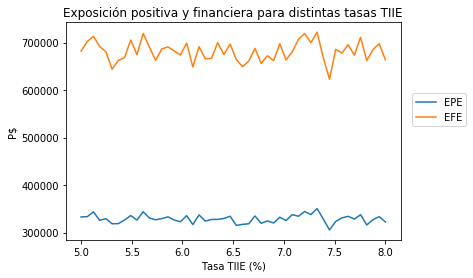

In [15]:
import matplotlib.pyplot as plt
TasaTIIE=np.linspace(.05,.08,50)
EPE=[]
EFE=[]
for t in TasaTIIE:
    ep,ef=CVA(vol,S0,ptos_fwd,tasa_USD_anual,p,TIIE=t,plazo=pl,nominal=noc,paso=pas)
    EPE.append(round(ep,2))
    EFE.append(round(ef,2))

fig=plt.figure()
plt.plot(100*TasaTIIE,EPE,label='EPE')
plt.plot(100*TasaTIIE,EFE,label='EFE')
plt.xlabel('Tasa TIIE (%)')
plt.ylabel('P$')
plt.legend(loc='lower center',bbox_to_anchor =(1.115,.5))
plt.title('Exposición positiva y financiera para distintas tasas TIIE')
plt.show()

## III. Creación del reporte

In [16]:
import xlwings as xw
archivo_excel=xw.Book()
hoja=archivo_excel.sheets['Hoja1']
hoja.range("A1").value="____________Reporte de Resultados: Resumen de CVA____________"
hoja.range("B3").value="1. Probabilidad de incumplimiento"
hoja.range("B5").value="      Instrumento usado para el cálculo"
hoja.range("B7").value="Descripción:"
hoja.range("B8").value="Fecha de hoy:"
hoja.range("B9").value="Maturity:"
hoja.range("B10").value="Frecuencia:"
hoja.range("B11").value="Precio cupón:"
hoja.range("B12").value="YTM:"
hoja.range("B13").value="Nominal:"
hoja.range("B14").value="Tasa Recuperación:"
hoja.range("B15").value="Proba. Incumplimiento:"

hoja.range("D7").value="Bono PEMEX"
d=str(current_day.day)
m=str(current_day.month)
if len(d)==1:
    d='0'+d
if len(m)==1:
    m="0"+m
hoja.range("D8").value=d+"/"+m+"/"+str(current_day.year)
hoja.range("D9").value=maturity_date
hoja.range("D10").value="S/A"
hoja.range("D11").value=str(100*cupon)+"%"
hoja.range("D12").value=str(100*YTM)+"%"
hoja.range("D13").value=str(nominal)
hoja.range("D14").value=str(100*R)+"%"
hoja.range("D15").value=str(round(100*h.x[0],3))+"%"

hoja.range("B17").value="2. Cálculo del CVA"
hoja.range("B19").value="Tipo de transacción:"
hoja.range("B20").value="FX FIX (28/03/2019):"
hoja.range("B21").value="Puntos forward:"
hoja.range("B22").value="tasa anual USD:"
hoja.range("B23").value="Volatilidad:"
hoja.range("B24").value="Tasa TIIE (28/03/2019):"
hoja.range("B25").value="Plazo (dias):"
hoja.range("B26").value="Nocional (P$):"
hoja.range("B27").value="Tamaño del paso:"
hoja.range("B28").value="CVA mediante EPE:"
hoja.range("B29").value="CVA mediante EFE:"
hoja.range("B30").value="Strike mediante EPE:"
hoja.range("B31").value="Strike mediante EFE:"

hoja.range("D19").value="P$ a USD$"
hoja.range("D20").value=str(S0)+" P$"
hoja.range("D21").value=str(ptos_fwd)
hoja.range("D22").value=str(100*tasa_USD_anual)+"%"
hoja.range("D23").value=str(100*vol)+"%"
hoja.range("D24").value=str(100*TIE)+"%"
hoja.range("D25").value=str(pl)
hoja.range("D26").value=str(noc)
hoja.range("D27").value=str(pas)
hoja.range("D28").value=str(round(epe,2))+" P$"
hoja.range("D29").value=str(round(efe,2))+" P$"
hoja.range("D30").value=str(round(precio_strike(S0,ptos_fwd,tasa_USD_anual,noc,pl,precio_fwd,epe)[0],2))+" P$"
hoja.range("D31").value=str(round(precio_strike(S0,ptos_fwd,tasa_USD_anual,noc,pl,precio_fwd,efe)[0],2))+" P$"

hoja.pictures.add(fig, name='TIIE', update=True,left=hoja.range('F5').left, top=hoja.range('F5').top,height=175,width=325)

<Picture 'TIIE' in <Sheet [Libro1]Hoja1>>